# Problem 13.1

## Part a

In [1]:
qui import delim ./data/chapter13/Middleton_Rogers_AI_2010, clear

rename relevant_measures_net Y
gen int Z=.
replace Z = 1 if treatment ==1
replace Z = 0 if treatment ==0

qui mean Y if Z==1
scalar avg_treat = _b[Y]
qui mean Y if Z==0
scalar avg_control = _b[Y]
global tau = avg_treat - avg_control

disp "average treatment effect = " $tau





(65 missing values generated)

(48 real changes made)

(17 real changes made)






average treatment effect = 90.20098


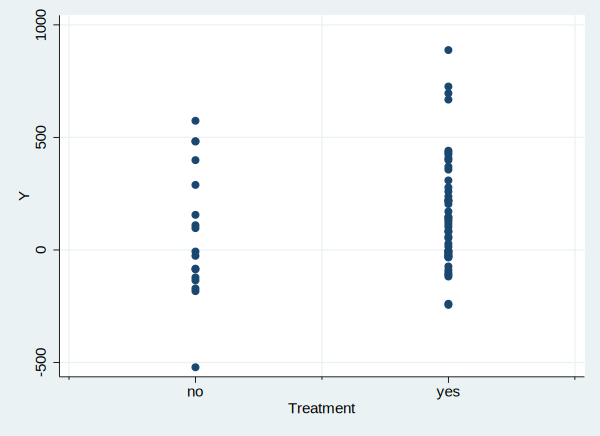





file ../results/chapter13/exercise_13_1_a_graph.pdf could not be opened


r(603);
r(603);


In [2]:
twoway (scatter Y Z), ///
xlabel(0"no" 1 "yes") xmtick(-0.5(1)1.5,grid) xtitle("Treatment")

graph export ../results/chapter13/exercise_13_1_a_graph.pdf	

## Part c

In [3]:
ritest Z ate_sim = _b[Z], ///
	reps(10000) sav(13_1_distout.dta, replace) right nodots: ///
	regress Y Z


      Source |       SS           df       MS      Number of obs   =        65
-------------+----------------------------------   F(1, 63)        =      1.50
       Model |  102140.815         1  102140.815   Prob > F        =    0.2248
    Residual |  4281899.43        63  67966.6576   R-squared       =    0.0233
-------------+----------------------------------   Adj R-squared   =    0.0078
       Total |  4384040.25        64  68500.6288   Root MSE        =     260.7

------------------------------------------------------------------------------
           Y |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
           Z |   90.20098   73.57996     1.23   0.225    -56.83684    237.2388
       _cons |   73.88235   63.23005     1.17   0.247    -52.47281    200.2375
------------------------------------------------------------------------------

      command:  regress Y Z
      ate_sim:  _b[Z]

In [4]:
// one-tail p-value
di %8.4f el(r(p), 1, 1)

  0.1119





(ritest Z : regress)


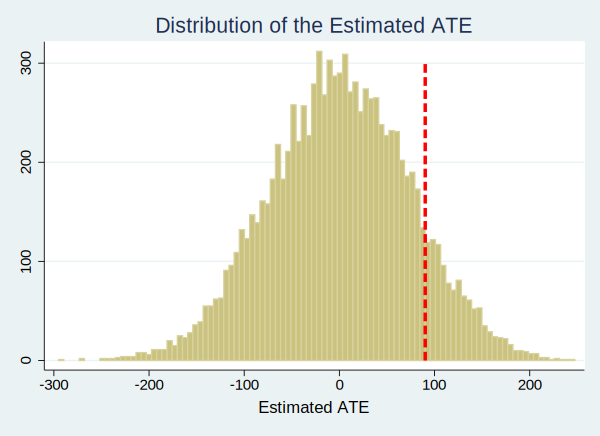





file ../results/chapter13/exercise_13_1_c_graph.pdf could not be opened


r(603);
r(603);


In [5]:
set more off
preserve
use "13_1_distout", clear
//historgam

graph twoway (histogram ate_sim,frequency bin(100)) ///
(scatteri 0 $tau 300 $tau, c(l) lc(red) lw(thick) lp(dash) m(i)), legend(off) ///
b1title("Estimated ATE") title("Distribution of the Estimated ATE") ///
xtitle("") 

graph export ../results/chapter13/exercise_13_1_c_graph.pdf	

restore

## Part d

In [6]:
clear
clear matrix
clear mata
set matsize 11000 
set maxvar 32767
set seed 67887975


cap matrix drop z
matrix z=J(65, 10000, .)

In [8]:
// restircted RA loop
qui forvalues i = 1/10000 {
	import delim ./data/chapter13/Middleton_Rogers_AI_2010, clear	
	tempvar teststat Z
	gen `Z' = .
	gen `teststat' = 5
	while (abs(`teststat')>=0.5){
		tempvar rannum ordering Zri 
	    gen `rannum'=uniform()
		egen `ordering' = rank(`rannum')
		gen `Zri' = 1 if `ordering' <= 48
		replace `Zri' = 0 if `ordering' > 48
				
		qui reg dem_perf_06 `Zri'		
		replace `teststat' = _b[`Zri']
	}
	replace `Z' = `Zri'
	forvalues j = 1/65 {
	matrix z[`j', `i'] = `Z'[`j']
	}
	drop _all
}

In [10]:
import delim ./data/chapter13/Middleton_Rogers_AI_2010, clear
rename relevant_measures_net Y
gen int Z=.
replace Z = 1 if treatment ==1
replace Z = 0 if treatment ==0


(3 vars, 65 obs)


(65 missing values generated)

(48 real changes made)

(17 real changes made)


In [11]:
matrix rowm = z * J(colsof(z), 1, 1/colsof(z))
matrix colnames rowm=probs
svmat double rowm, names(col)


In [12]:
// distribution of probabilities
tabstat probs, stat(min p25 med mean p75 max)


    variable |       min       p25       p50      mean       p75       max
-------------+------------------------------------------------------------
       probs |     .7263     .7341      .737  .7384615     .7425     .7619
--------------------------------------------------------------------------


In [13]:
svmat z

In [14]:
cap matrix drop tau_dis
matrix tau_dis=J(10000, 1, .)


// calculate estimate distribution
forvalues i = 1/10000{
	tempvar weight`i'
	gen `weight`i'' = z`i'/probs + (1 - z`i')/(1 - probs)
	qui reg Y z`i' [pw=`weight`i'']
	matrix tau_dis[`i', 1] = _b[z`i']	

}

In [15]:
set more off



number of observations will be reset to 10000
Press any key to continue, or Break to abort
number of observations (_N) was 65, now 10,000


.0238


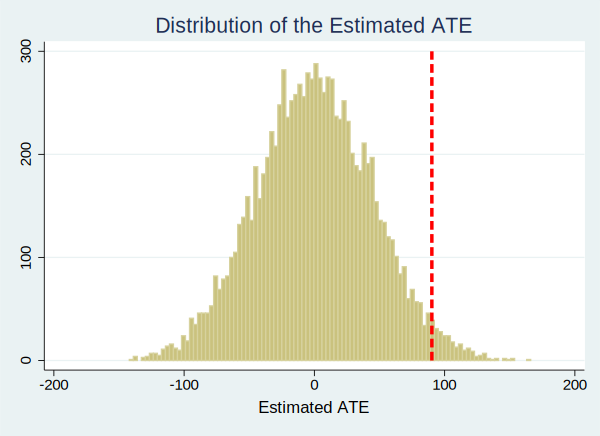





file ../results/chapter13/exercise_13_1_d_graph.pdf could not be opened


r(603);
r(603);


In [18]:
preserve
svmat tau_dis
qui count if tau_dis1 > $tau
// one tailed p-value
di r(N)/_N

graph twoway (histogram tau_dis1,frequency bin(100)) ///
(scatteri 0 $tau 300 $tau, c(l) lc(red) lw(thick) lp(dash) m(i)), legend(off) ///
b1title("Estimated ATE") title("Distribution of the Estimated ATE") ///
xtitle("") 

graph export ../results/chapter13/exercise_13_1_d_graph.pdf	

restore 